## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import shap

## Reading data

Note that we dismiss Canary Islands, Balearic Islands Ceuta and Melilla because they are not considered in the demand data 

In [2]:
cities = pd.read_csv('cities_unified.csv', header = 0)
cities = cities[(cities['Provincias'] != 'Melilla') & (cities['Provincias'] != 'Ceuta') & (cities['Provincias'] != 'Santa Cruz de Tenerife') & (cities['Provincias'] != 'Palmas, Las') & (cities['Provincias'] != 'Balears, Illes')]
cities.reset_index(drop=True, inplace = True)
cities.index=cities['Codigos']
cities.tail()

,Codigos,Provincias,Latitud,Longitud,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Codigos,,,,,,,,,,,,,,
47,47,Valladolid,41.634126,-4.847191,529157,526288,523679,521130,519851,519546,520649,519361,517975,521333
48,48,Bizkaia,43.237680,-2.852600,1151905,1148775,1147576,1148302,1149628,1152651,1159443,1154334,1149344,1153282
49,49,Zamora,41.727174,-5.980539,185432,183436,180406,177404,174549,172539,170588,168725,167215,166927
50,50,Zaragoza,41.620365,-1.064497,960111,956006,950507,953486,954811,964693,972528,967452,966438,979365
0,0,TOTAL ESPAÑA,39.695119,-3.202023,46771341,46624382,46557008,46572132,46722980,47026208,47450795,47385107,47475420,48085361


In [3]:
ipc = pd.read_csv('IPC.csv', header = 0)
ipc = ipc[(ipc['Provincia'] != 'Melilla') & (ipc['Provincia'] != 'Ceuta') & (ipc['Provincia'] != 'Santa Cruz de Tenerife') & (ipc['Provincia'] != 'Palmas, Las') & (ipc['Provincia'] != 'Balears, Illes')]
ipc.reset_index(drop=True, inplace = True)
ipc.tail()

,Codigo,Provincia,1-2014,2-2014,3-2014,4-2014,5-2014,6-2014,7-2014,8-2014,...,3-2023,4-2023,5-2023,6-2023,7-2023,8-2023,9-2023,10-2023,11-2023,12-2023
43,47,Valladolid,93498,93451,93566,94419,94369,94419,93600,93776,...,111670,112360,112194,112770,112780,113328,113457,114086,113459,113537
44,48,Bizkaia,92529,92402,92640,93555,93525,93561,92738,92900,...,111128,111660,111744,112665,112700,113205,113485,113534,113198,113152
45,49,Zamora,93284,93234,93511,94390,94414,94352,93307,93525,...,113086,113937,113791,114536,114620,115011,115115,115517,114885,115055
46,50,Zaragoza,93588,93570,93708,94676,94661,94614,93792,93965,...,110967,111417,111269,111873,112310,112893,112907,113042,112828,112710
47,0,TOTAL ESPAÑA,93373,93333,93541,94373,94395,94421,93533,93681,...,111111,111773,111719,112354,112544,113149,113348,113676,113280,113308


In [4]:
ipc.columns

Index(['Codigo', 'Provincia', '1-2014', '2-2014', '3-2014', '4-2014', '5-2014',
       '6-2014', '7-2014', '8-2014',
       ...
       '3-2023', '4-2023', '5-2023', '6-2023', '7-2023', '8-2023', '9-2023',
       '10-2023', '11-2023', '12-2023'],
      dtype='object', length=122)

In [5]:
demanda_meteo = pd.read_csv('demanda_meteo.csv', header = 0)
demanda_meteo['Datetime'] = pd.to_datetime(demanda_meteo['Datetime'])
demanda_meteo.head()

,Datetime,Demanda Real,Demanda Prevista,Demanda Programada,Demanda D+1,Precio,temperature_2m_1,direct_normal_irradiance_instant_1,wind_speed_100m_1,temperature_2m_2,...,wind_speed_100m_50,temperature_2m_51,direct_normal_irradiance_instant_51,wind_speed_100m_51,temperature_2m_52,direct_normal_irradiance_instant_52,wind_speed_100m_52,temperature_2m_0,direct_normal_irradiance_instant_0,wind_speed_100m_0
0,2014-01-01 00:00:00,24301.66667,23878.33333,24099.0,0.0,37.21,7.4985,0.0,16.099690,7.874,...,30.758411,11.714001,0.0,17.339897,10.032000,0.0,11.659777,5.791485,0.0,18.565381
1,2014-01-01 01:00:00,23365.33333,23322.00000,22269.0,0.0,30.57,7.0485,0.0,17.388409,7.724,...,30.312773,11.614000,0.0,18.000000,9.731999,0.0,10.661107,5.709594,0.0,18.443398
2,2014-01-01 02:00:00,21672.50000,21711.16667,21136.0,0.0,26.30,7.3985,0.0,19.319628,7.574,...,27.792374,11.564000,0.0,17.651016,9.932000,0.0,11.212135,5.620734,0.0,18.401250
3,2014-01-01 03:00:00,20192.00000,20230.33333,19911.0,0.0,26.18,7.3485,0.0,20.140705,7.424,...,25.772078,11.464001,0.0,18.430452,10.432000,0.0,12.620554,5.597380,0.0,18.198554
4,2014-01-01 04:00:00,19220.66667,19215.33333,19060.0,0.0,22.40,7.4985,0.0,21.995380,7.374,...,23.732710,11.464001,0.0,18.161278,10.582000,0.0,14.058450,5.656951,0.0,18.100382


In [6]:
festivos = pd.read_csv('Festivos.csv', header = 0)
festivos['Day'] = pd.to_datetime(festivos['Day'])
festivos = festivos.drop(['Melilla', 'Ceuta', 'Santa Cruz de Tenerife', 'Palmas, Las', 'Balears, Illes'], axis = 1)
festivos.head()

,Day,Day of the week,"Coruña, A",Albacete,Alicante/Alacant,Almería,Araba/Álava,Asturias,Badajoz,Barcelona,...,Soria,Tarragona,Teruel,Toledo,Valencia/València,Valladolid,Zamora,Zaragoza,Ávila,sumafest
0,2014-01-01,X,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1.000000
1,2014-01-02,J,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.019659
2,2014-01-03,V,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
3,2014-01-04,S,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
4,2014-01-05,D,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.000000


In [7]:
pib = pd.read_csv('PIB.csv', header = 0)
pib.head()

,Codigo,Provincia,1-2014,2-2014,3-2014,4-2014,5-2014,6-2014,7-2014,8-2014,...,3-2023,4-2023,5-2023,6-2023,7-2023,8-2023,9-2023,10-2023,11-2023,12-2023
0,0,TOTAL ESPAÑA,925468,925468,925468,969598,969598,969598,960418,960418,...,1099141,1139036,1139036,1139036,1127405,1127405,1127405,1171293,1171293,1171293


## X and Y creation and definition of the metrics

In [8]:
ndays_base = 28
ntemps = 5
nrads = 5
normalization = True
name_file = str(ndays_base)+'Days-'+str(ntemps)+'Temps-'+str(nrads)+'Rads.csv'

In [9]:
combined_base = pd.read_csv('./Base Inputs/Variations/'+name_file,header=0)

In [10]:
combined_base['Datetime'] = pd.to_datetime(combined_base['Datetime'])

In [11]:
base = {x:combined_base[combined_base['Datetime'].dt.hour==x] for x in range (24)}
for h in range (24):
    base[h] = base[h].reset_index(drop=True)

In [12]:
if normalization:
    cols = base[0].columns
    normalization_parameters = {i:[] for i in cols[4:]}
    for name in cols[4:]:
        aux = []
        for h in range (24):
            n = len(base[h])
            for j in range (n):
                aux.append(base[h][name][j])
        delta = max(aux)-min(aux)
        minimo = min(aux)
        normalization_parameters[name].append(delta)
        normalization_parameters[name].append(minimo)
        aux = (aux - min(aux))/(max(aux)-min(aux))
        for h in range(24):
            base[h][name] = aux[n*h:n*(h+1)]
    base[0]
    normalization_parameters = pd.DataFrame(normalization_parameters)
    normalization_parameters = normalization_parameters.rename(index={0: 'Delta', 1: 'Minimo'})
    print(normalization_parameters)

          F         L        M        X         J         V        S  \
Delta   1.0  5.784642  7.22602  7.22602  7.244857  7.244857  7.22602   
Minimo  0.0  0.000000  0.00000  0.00000  0.000000  0.000000  0.00000   

             IPC       Demanda  Temp_Ocean  ...  Temp_Med_S  Temp_Arido  \
Delta   0.049660  19473.440477   24.296530  ...   25.021825   28.537216   
Minimo  0.980921  18153.351190  -12.109515  ...  -13.621727  -15.437454   

        Temp_Cont    Rad_Ocean    Rad_Med_N    Rad_Med_S    Rad_Arido  \
Delta   26.177648  1228.312175  1464.261728  1347.446777  1444.313131   
Minimo -13.733033  -594.248623  -779.341384  -765.815529  -835.420535   

           Rad_Cont     Viento      Precio  
Delta   1265.719331  45.945262  351.530714  
Minimo  -729.556146 -16.960417   11.779643  

[2 rows x 21 columns]


In [13]:
años_train = 8
años_validation = 1
años_test = 10 - años_train - años_validation

start_year = 2014
days_year = [365,365,366,365,365,365,366,365,365,365]
days_month = [31,28,31,30,31,30,31,31,30,31,30,31]
days_bisiesto = [31,29,31,30,31,30,31,31,30,31,30,31]

days_training = sum (days_year[:años_train])
hours_training = 24*days_training

days_validation = sum (days_year[años_train:años_train+años_validation])
hours_validation = 24*days_validation

days_testing = sum(days_year[años_train+años_validation:])
hours_testing = 24*days_testing

In [14]:
x = {i:[] for i in range (0,24)}
y = {i:[] for i in range (0,24)}
x_train = {i:[] for i in range (0,24)}
x_val = {i:[] for i in range (0,24)}
x_test = {i:[] for i in range (24)}
y_train = {i:[] for i in range (0,24)}
y_val = {i:[] for i in range (0,24)}
y_test = {i:[] for i in range (24)}
prevision = {i:[] for i in range (0,24)}
prevision_train = {i:[] for i in range (0,24)}
prevision_val = {i:[] for i in range (0,24)}
prevision_test = {i:[] for i in range (0,24)}

In [15]:
for h in range (24):
    aux = base[h]
    
    filtered_df = aux[aux['Datetime'].dt.year - start_year < años_train]
    for index, row in filtered_df.iterrows():
        x_train[h].append(row[1:]) ## dropeamos datetime

    filtered_df = aux[(aux['Datetime'].dt.year - start_year - años_train < años_validation) & (aux['Datetime'].dt.year - start_year - años_train >= 0) ]
    for index, row in filtered_df.iterrows():
        x_val[h].append(row[1:]) ## dropeamos datetime

    filtered_df = aux[(aux['Datetime'].dt.year - start_year - años_train - años_validation < años_test) & (aux['Datetime'].dt.year - start_year - años_train - años_validation >= 0)]
    for index, row in filtered_df.iterrows():
        x_test[h].append(row[1:]) ## dropeamos datetime

    x[h] = x_train[h] + x_val[h] + x_test[h] 

In [16]:
threshold = combined_base['Datetime'][0]
auxdemanda = demanda_meteo[demanda_meteo['Datetime']>=threshold]
auxdemanda.reset_index(drop=True, inplace=True)
print (auxdemanda['Datetime'][0])
for i in range (len(auxdemanda)):
    h = auxdemanda['Datetime'][i].hour
#     print (h)
    if normalization:
        real = (auxdemanda['Demanda Real'][i] - normalization_parameters['Demanda']['Minimo'])/normalization_parameters['Demanda']['Delta']
        prevista = (auxdemanda['Demanda Prevista'][i] - normalization_parameters['Demanda']['Minimo'])/normalization_parameters['Demanda']['Delta']
    else:
        real = auxdemanda['Demanda Real'][i]
        prevista = auxdemanda['Demanda Prevista'][i]
    
    y[h].append(real)
    prevision[h].append(prevista)

    if (auxdemanda['Datetime'][i].year- start_year < años_train):
        y_train[h].append(real)
        prevision_train[h].append(prevista)

    elif (auxdemanda['Datetime'][i].year- start_year - años_train < años_validation):
        y_val[h].append(real)
        prevision_val[h].append(prevista)

    elif (auxdemanda['Datetime'][i].year - start_year - años_train - años_validation < años_test):
        y_test[h].append(real)
        prevision_test[h].append(prevista)

2014-02-01 00:00:00


In [17]:
for h in range (24):
    print ('x (', h, '): ', len(x[h]), len(x_train[h]), len(x_val[h]), len(x_test[h]))
    print ('y (', h, '): ', len(y[h]), len(y_train[h]), len(y_val[h]), len(y_test[h]))

x ( 0 ):  3621 2891 365 365
y ( 0 ):  3621 2891 365 365
x ( 1 ):  3621 2891 365 365
y ( 1 ):  3621 2891 365 365
x ( 2 ):  3621 2891 365 365
y ( 2 ):  3621 2891 365 365
x ( 3 ):  3621 2891 365 365
y ( 3 ):  3621 2891 365 365
x ( 4 ):  3621 2891 365 365
y ( 4 ):  3621 2891 365 365
x ( 5 ):  3621 2891 365 365
y ( 5 ):  3621 2891 365 365
x ( 6 ):  3621 2891 365 365
y ( 6 ):  3621 2891 365 365
x ( 7 ):  3621 2891 365 365
y ( 7 ):  3621 2891 365 365
x ( 8 ):  3621 2891 365 365
y ( 8 ):  3621 2891 365 365
x ( 9 ):  3621 2891 365 365
y ( 9 ):  3621 2891 365 365
x ( 10 ):  3621 2891 365 365
y ( 10 ):  3621 2891 365 365
x ( 11 ):  3621 2891 365 365
y ( 11 ):  3621 2891 365 365
x ( 12 ):  3621 2891 365 365
y ( 12 ):  3621 2891 365 365
x ( 13 ):  3621 2891 365 365
y ( 13 ):  3621 2891 365 365
x ( 14 ):  3621 2891 365 365
y ( 14 ):  3621 2891 365 365
x ( 15 ):  3621 2891 365 365
y ( 15 ):  3621 2891 365 365
x ( 16 ):  3621 2891 365 365
y ( 16 ):  3621 2891 365 365
x ( 17 ):  3621 2891 365 365
y ( 1

In [18]:
exog_train = {}
exog_val = {}
exog_test = {}
exog_train_val = {}
exog_train_val_test = {}

for h in range (24):
    exog_train[h] = base[h][base[h]['Datetime'].dt.year - start_year < años_train]
    exog_val[h] = base[h][(base[h]['Datetime'].dt.year - start_year - años_train < años_validation) & (base[h]['Datetime'].dt.year - start_year - años_train >= 0) ]
    exog_test[h] = base[h][(base[h]['Datetime'].dt.year - start_year - años_train - años_validation < años_test) & (base[h]['Datetime'].dt.year - start_year - años_train - años_validation >= 0)]

    exog_train[h] = exog_train[h].drop(['Datetime', 'Demanda', 'Precio', 'IPC', 'Viento'], axis=1)
    exog_val[h] = exog_val[h].drop(['Datetime', 'Demanda', 'Precio', 'IPC', 'Viento'], axis=1)
    exog_test[h] = exog_test[h].drop(['Datetime', 'Demanda', 'Precio', 'IPC', 'Viento'], axis=1)

    # Concatenate exog_train and exog_val into a single DataFrame
    exog_train_val[h] = pd.concat([exog_train[h], exog_val[h]]).reset_index(drop=True)

    exog_train_val_test[h] = pd.concat([exog_train_val[h], exog_test[h]]).reset_index(drop=True)
    
    exog_test[h] = exog_test[h].reset_index(drop=True)

In [19]:
exog_train_val_test[0]

,Day,Month,Week,F,L,M,X,J,V,S,Temp_Ocean,Temp_Med_N,Temp_Med_S,Temp_Arido,Temp_Cont,Rad_Ocean,Rad_Med_N,Rad_Med_S,Rad_Arido,Rad_Cont
0,1,2,5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.785366,0.603328,0.474539,0.597797,0.597855,0.588823,0.483793,0.532242,0.568346,0.578421,0.576396
1,2,2,5,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.309975,0.483742,0.478732,0.445345,0.346110,0.483793,0.532242,0.568346,0.578421,0.576396
2,3,2,6,0.0,0.820494,0.000000,0.000000,0.000000,0.000000,0.000000,0.397536,0.377553,0.433728,0.381455,0.355996,0.483793,0.532242,0.568346,0.578421,0.576396
3,4,2,6,0.0,0.000000,0.785366,0.000000,0.000000,0.000000,0.000000,0.338823,0.403649,0.441423,0.392601,0.374281,0.483793,0.532242,0.568346,0.578421,0.576396
4,5,2,6,0.0,0.000000,0.000000,0.976449,0.000000,0.000000,0.000000,0.495015,0.572244,0.605977,0.615357,0.582363,0.483793,0.532242,0.568346,0.578421,0.576396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3616,27,12,52,0.0,0.000000,0.000000,0.532522,0.000000,0.000000,0.000000,0.363021,0.392030,0.423881,0.360370,0.318847,0.483793,0.532242,0.568346,0.578421,0.576396
3617,28,12,52,0.0,0.000000,0.000000,0.000000,0.531137,0.000000,0.000000,0.525062,0.476685,0.404922,0.360419,0.363748,0.483793,0.532242,0.568346,0.578421,0.576396
3618,29,12,52,0.0,0.000000,0.000000,0.000000,0.000000,0.532124,0.000000,0.565506,0.422100,0.521166,0.441696,0.456431,0.483793,0.532242,0.568346,0.578421,0.576396
3619,30,12,52,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.533512,0.515520,0.501825,0.532002,0.475048,0.547176,0.483793,0.532242,0.568346,0.578421,0.576396


In [20]:
lags = [i for i in range (2, ndays_base+1)]

# Definitions of functions that will be used later

In [21]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor

def fit_model (y_,flag_exog,exog, lags=lags,model=XGBRegressor()):
    
    # Crear el forecaster
    # ==============================================================================
    forecaster = ForecasterAutoreg(
                     regressor = model,
                     lags = lags
                 )

    # Entrena el forecaster
    # ==============================================================================
    if flag_exog:
        forecaster.fit(y=pd.Series(y_), 
                         exog=exog)
    else:
        forecaster.fit(y=pd.Series(y_))
    
    return forecaster

In [22]:
def predict (forecaster, y_, start, npreds, flag_exog, exog, lags=lags,steps = 1):
    cont = 0
    preds_list = []
    start_window = start-max(lags)
    end_window = start
    while cont < npreds:
        window = pd.Series(y_[start_window:end_window])

        if flag_exog:
            window_exog = exog.loc[cont:cont+steps]
            window_exog = window_exog.reset_index(drop=True, inplace=False)
            window_exog.index = window_exog.index + len(window)
    #         print (window_exog)
            preds = forecaster.predict(steps=steps,last_window=window,exog=window_exog)

        else:
            preds = forecaster.predict(steps=steps,last_window=window)

        preds_list.append(list(preds))

        cont += steps
        start_window += steps
        end_window += steps

    predictions = [item for sublist in preds_list for item in sublist]
    
    return predictions

In [23]:
def scatter_predictions (h,y_,predictions):
    plt.title ('Real vs Predicted para las ' +  str(h) +  'h')
    plt.scatter(y_, predictions)
    plt.plot([min(min(y_),min(predictions)),max(max(y_),max(predictions))], [min(min(y_),min(predictions)),max(max(y_),max(predictions))])
    plt.xlabel('Real')
    plt.ylabel('Predicted')
    plt.show()

In [24]:
def plot_evolution (h,y_,predictions,prevision,ndias=100):
    plt.title ('Predicciones para las ' +  str(h) +  'h')
    plt.plot(predictions[:ndias], label = 'XGB')
    plt.plot(y_[:ndias], label = 'Validation set')
    plt.plot(prevision[:ndias], label = 'Prevision')
    plt.legend(loc='lower left')
    plt.show()

In [25]:
def metrics (preds, val, normalized = normalization):
    df = {}
    combined_df = pd.DataFrame()
    overall = []
    for h in range (24):
        aux = {}
        if normalized:
            auxpreds = np.array(preds[h])*normalization_parameters['Demanda']['Delta']+normalization_parameters['Demanda']['Minimo']
            auxval = np.array(val[h])*normalization_parameters['Demanda']['Delta']+normalization_parameters['Demanda']['Minimo']
        else:
            auxpreds = np.array(preds[h])
            auxval = np.array(val[h])
#         datetest = base[h]
        aux['Datetime'] = base[h][(base[h]['Datetime'].dt.year - start_year - años_train - años_validation < años_test) & (base[h]['Datetime'].dt.year - start_year - años_train - años_validation >= 0)]['Datetime']
        aux['Error'] = auxpreds-auxval
        aux['Absolute Error'] = abs(aux['Error'])
        aux['Squared Error'] = (auxpreds-auxval)*(auxpreds-auxval)
        aux['Relative Error'] = 100*abs((auxpreds-auxval)/auxval)
        
#         print([[name, len(aux[name])] for name in aux.keys()])
        df[h] = pd.DataFrame(aux)
        df[h]['Datetime'] = pd.to_datetime(df[h]['Datetime'], format='%d-%m-%Y')# + pd.DateOffset(hours=h)
        df[h]['Datetime'] = pd.to_datetime(df[h]['Datetime'])
        combined_df = pd.concat((combined_df, df[h]))
        overall.append([h,np.sqrt(np.mean(df[h]['Error']*df[h]['Error'])), np.mean(df[h]['Absolute Error']), np.mean(df[h]['Relative Error']), max(df[h]['Absolute Error'])])

    # Assuming your dictionary is named 'data_dict'
    # Concatenate dataframes from the dictionary into one large dataframe
#     combined_df = pd.concat([d.assign(datetime=pd.to_datetime(df['Datetime'], format='%d-%m-%Y') + pd.DateOffset(hours=hour)) 
#                              for hour, d in df.items()])
#     combined_df = pd.concat([d for d in df.items()])

    # Sort the dataframe by the datetime column
    combined_df = combined_df.sort_values(by='Datetime')

    # Convert datetime column to the desired format (day-month-year hour)
#     combined_df['Datetime'] = combined_df['Datetime'].dt.strptime(combined_df['Datetime'], '%Y-%m-%d %H:%M:%S')

    # Optionally, reset index if needed
    combined_df = combined_df.reset_index(drop=True)

    # Now, combined_df contains the concatenated and sorted dataframe with the desired datetime format,
    # where the hour comes from the key of the dictionary
    
    return combined_df,overall
#     return combined_df

In [26]:
def indexes_of_max_and_min_mae(arr):
    if not arr:
        return None, None
    
    # Extract third components from each sublist
    third_components = [sublist[2] for sublist in arr]
    
    # Find index of minimum and maximum third components
    min_index = third_components.index(min(third_components))
    max_index = third_components.index(max(third_components))
    
    return [min_index, max_index]

def shap_information (forecaster, y_, flag_exog, exog):
    if flag_exog:
        a, _ = forecaster.create_train_X_y(
            y=pd.Series(y_), 
            exog=exog)
    else:
        a, _ = forecaster.create_train_X_y(
            y=pd.Series(y_))
        
    explainer = shap.TreeExplainer(forecaster.regressor)
    shap_values = explainer.shap_values(a)
    shap.summary_plot(shap_values, a, plot_type="bar")
    shap.summary_plot(shap_values, a)
    return shap_values

# LGBM with exog

In [27]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor

forecaster_exog = {}

for h in range (24):

    # Crear el forecaster
    # ==============================================================================
    forecaster_exog[h] = ForecasterAutoreg(
#                      regressor = LGBMRegressor(verbose=-1),
                     regressor = XGBRegressor (),
    #                  lags = [1, 2, 3] + [24*i-1 for i in range(1, 8)] + [24*i for i in range(1, 8)] + [24*i+1 for i in range(1, 8)]
                     lags = lags
                 )
    
#     print (len(y_train[h]))
    # Entrena el forecaster
    # ==============================================================================
    forecaster_exog[h].fit(y=pd.Series(y_train[h]+y_val[h]), 
                     exog=exog_train_val[h])

In [28]:
exog_predictions = {}
for h in range (24):
    exog_predictions[h] = predict (forecaster_exog[h], y[h], len(y_train[h]+y_val[h]), len(y_test[h]), True, exog_test[h])

In [29]:
df_exog, exog_metrics = metrics(exog_predictions, y_test)
exog_metrics

[[0,
  895.2345072191594,
  656.1351559226789,
  2.739808657813407,
  3693.154244527381],
 [1,
  794.9590163139795,
  577.8203736497023,
  2.5658997697955437,
  3771.430830881058],
 [2,
  776.08354706719,
  564.2295840702311,
  2.608901035988552,
  2991.4143103502647],
 [3,
  721.9537665695331,
  520.0548636834636,
  2.4631696081708365,
  3474.122540012024],
 [4,
  726.6515525105968,
  524.8986631583107,
  2.546519843990519,
  3581.0618384108275],
 [5,
  679.263491006104,
  519.6945693900265,
  2.4792127227517744,
  3084.6454043113554],
 [6,
  704.2388889862615,
  524.7262801386404,
  2.3526310114155953,
  3349.091274013994],
 [7,
  974.5652623331422,
  695.7180634432721,
  2.8551966805171536,
  5233.543529857379],
 [8,
  1033.6350424544862,
  752.2829769079889,
  2.898101630755424,
  5136.67085210131],
 [9,
  1182.5893484149378,
  878.4929634499539,
  3.2564329769211677,
  4754.010917911659],
 [10,
  1291.6925307397796,
  925.6381436408022,
  3.460364977243317,
  6443.855143343411],
 

In [30]:
exog_metrics_mean = np.mean(np.array(exog_metrics),axis=0)
exog_metrics_mean = list (exog_metrics_mean [1:])
exog_metrics_mean

[1106.5634077635098, 834.3180651560946, 3.2380357363245404, 4498.902544089661]

In [31]:
min_max_hours = indexes_of_max_and_min_mae (exog_metrics)

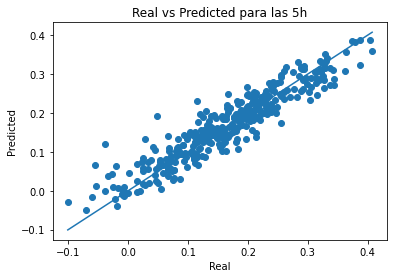

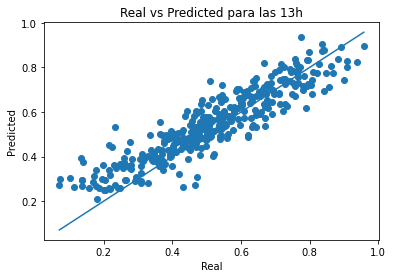

In [32]:
for h in min_max_hours:
    scatter_predictions (h,y_test[h],exog_predictions[h])

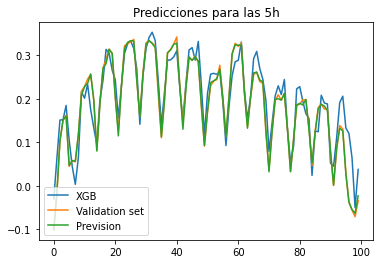

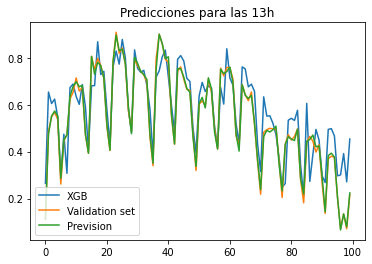

In [33]:
for h in min_max_hours:
    plot_evolution (h,y_test[h],exog_predictions[h],prevision_test[h])

SHAP INFORMATION FOR 5h


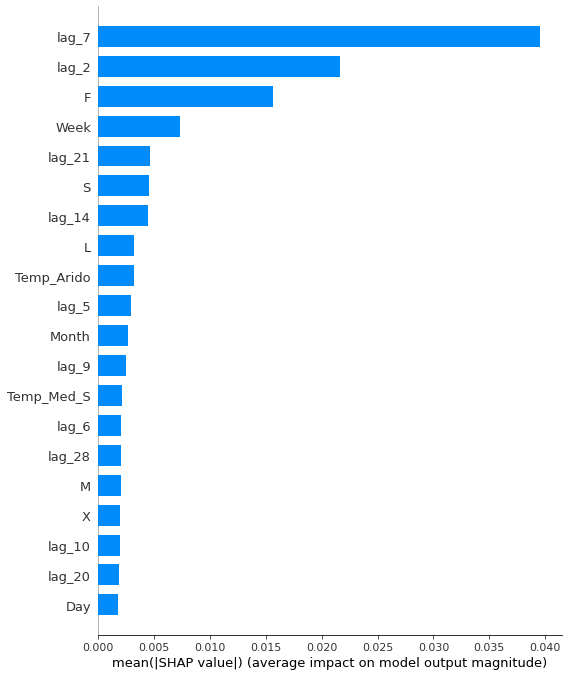

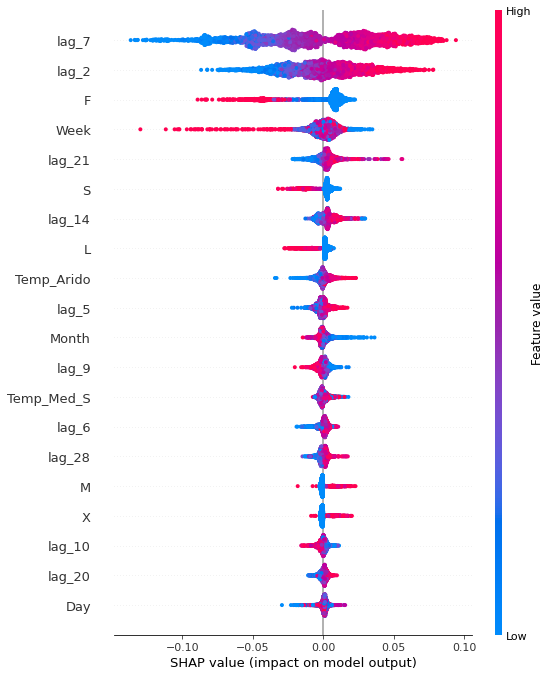

-------------------------



SHAP INFORMATION FOR 13h


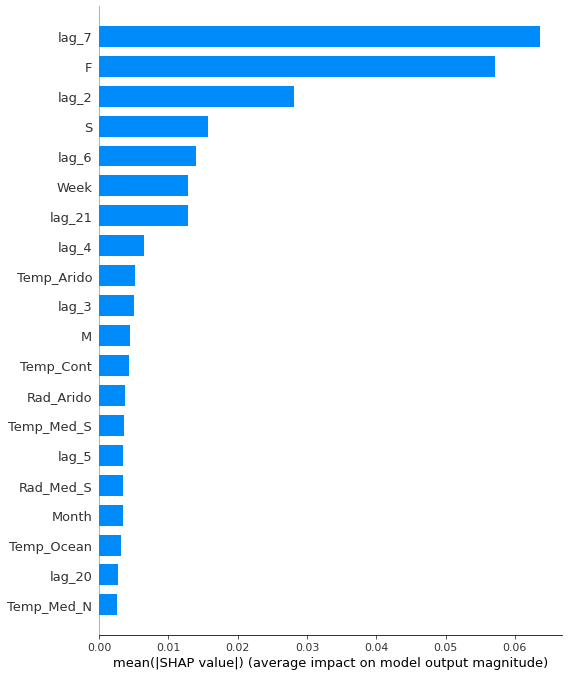

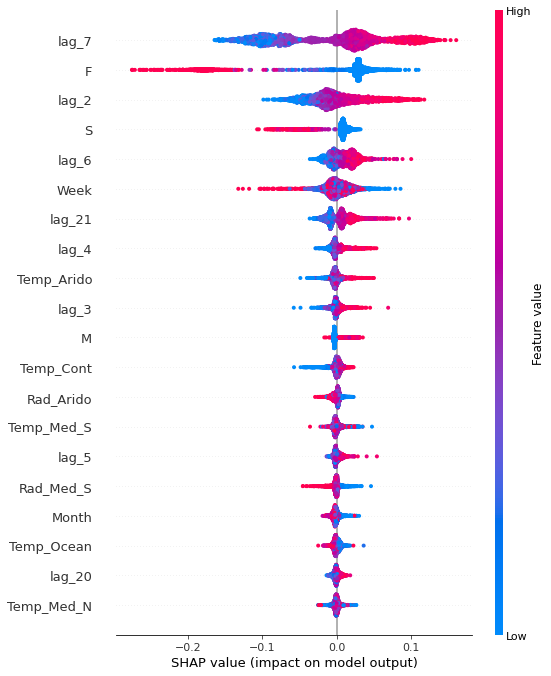

-------------------------





In [34]:
for h in min_max_hours:
    print ('SHAP INFORMATION FOR ' + str(h)+'h')
    shap_information (forecaster_exog[h], y_train[h]+y_val[h], True, exog_train_val[h])
    print ('-------------------------\n\n\n')

# LGBM with exog and hyperparameter tuning

In [35]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor

forecaster_opt = {}

for h in range (24):

    # Crear el forecaster
    # ==============================================================================
    forecaster_opt[h] = ForecasterAutoreg(
#                      regressor = LGBMRegressor(verbose=-1),
                     regressor = XGBRegressor (),
    #                  lags = [1, 2, 3] + [24*i-1 for i in range(1, 8)] + [24*i for i in range(1, 8)] + [24*i+1 for i in range(1, 8)]
                     lags = lags
                 )

    # Entrena el forecaster
    # ==============================================================================
    forecaster_opt[h].fit(y=pd.Series(y_train[h]+y_val[h]), 
                     exog=exog_train_val[h])

In [36]:
from skforecast.model_selection import bayesian_search_forecaster

resultados_busqueda = {}

for h in range (24):

    # Espacio de búsqueda de hiperparámetros
    def search_space(trial):
        search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 100, 1500, step=20),
        'max_depth'     : trial.suggest_int('max_depth', 3, 15, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.0001, 0.5, log=True),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0.001, 1, log=True),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0.001, 1, log=True),
        'subsample'    : trial.suggest_float('subsample', 0, 1),
    } 
        return search_space

    resultados_busqueda[h], frozen_trial = bayesian_search_forecaster(
                                            forecaster         = forecaster_opt[h],
                                            y                  = pd.Series(y_train[h]+y_val[h]),
                                            exog               = exog_train_val[h],
                                            steps              = 1,
                                            metric             = 'mean_squared_error',
                                            search_space       = search_space,
                                            initial_train_size = len(y_train[h]),
                                            refit              = False,
                                            n_trials           = 30, # Aumentar para una búsqueda más exhaustiva
    #                                         random_state       = 123,
                                            return_best        = True,
                                            n_jobs             = 'auto',
                                            verbose            = False,
                                            show_progress      = True
                                        )

    resultados_busqueda[h]

  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 1400, 'max_depth': 4, 'learning_rate': 0.06212529859246311, 'reg_alpha': 0.17844827394914453, 'reg_lambda': 0.0024505120594403604, 'subsample': 0.9132923982920714}
  Backtesting metric: 0.0013774406843560085



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 1160, 'max_depth': 3, 'learning_rate': 0.06652603360390137, 'reg_alpha': 0.5719494307558919, 'reg_lambda': 0.002830760549542428, 'subsample': 0.8078113443731919}
  Backtesting metric: 0.0011933520953051643



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 980, 'max_depth': 3, 'learning_rate': 0.26511003360904445, 'reg_alpha': 0.9663798722510138, 'reg_lambda': 0.002046907126554925, 'subsample': 0.6906413515227443}
  Backtesting metric: 0.0011130694665590912



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 1260, 'max_depth': 4, 'learning_rate': 0.20677063376952076, 'reg_alpha': 0.16988955057738858, 'reg_lambda': 0.0010335910798865819, 'subsample': 0.8752036004851282}
  Backtesting metric: 0.0010963958302049328



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 1380, 'max_depth': 4, 'learning_rate': 0.05362241317557882, 'reg_alpha': 0.05630918600235428, 'reg_lambda': 0.010540862412650585, 'subsample': 0.5659631880601925}
  Backtesting metric: 0.0009458373727890246



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 1380, 'max_depth': 3, 'learning_rate': 0.04300198344275517, 'reg_alpha': 0.009403253301258277, 'reg_lambda': 0.005969208005790045, 'subsample': 0.48147720260330756}
  Backtesting metric: 0.0010298153666688954



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 840, 'max_depth': 4, 'learning_rate': 0.09038947123949975, 'reg_alpha': 0.3490741876167178, 'reg_lambda': 0.21253941743159496, 'subsample': 0.4158983334174017}
  Backtesting metric: 0.0012955647110928317



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 1060, 'max_depth': 7, 'learning_rate': 0.012458944155266823, 'reg_alpha': 0.08313996765021552, 'reg_lambda': 0.002686600210559261, 'subsample': 0.6442396388307152}
  Backtesting metric: 0.001791334332587352



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 1240, 'max_depth': 6, 'learning_rate': 0.04359277794752379, 'reg_alpha': 0.08358456274356575, 'reg_lambda': 0.4019512388977329, 'subsample': 0.4889092130867139}
  Backtesting metric: 0.0024013497635405738



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 940, 'max_depth': 5, 'learning_rate': 0.012676842960471873, 'reg_alpha': 0.21266254540922025, 'reg_lambda': 0.519772758414139, 'subsample': 0.6605145600921463}
  Backtesting metric: 0.00302928841344286



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 840, 'max_depth': 3, 'learning_rate': 0.03315175677869354, 'reg_alpha': 0.3975381185761691, 'reg_lambda': 0.20715223955109782, 'subsample': 0.3890668642636766}
  Backtesting metric: 0.0034674251245070575



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 1380, 'max_depth': 4, 'learning_rate': 0.0485234348723276, 'reg_alpha': 0.056317210870007954, 'reg_lambda': 0.5126870962266883, 'subsample': 0.19839196952338545}
  Backtesting metric: 0.0034357585750422605



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 1240, 'max_depth': 5, 'learning_rate': 0.01158737579766605, 'reg_alpha': 0.06825474163214298, 'reg_lambda': 0.010306546163788491, 'subsample': 0.6519265680880005}
  Backtesting metric: 0.003907700150151682



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 1260, 'max_depth': 5, 'learning_rate': 0.008183914568000382, 'reg_alpha': 0.0031624915042671605, 'reg_lambda': 0.007459529759898519, 'subsample': 0.2504937450339028}
  Backtesting metric: 0.0038749890222243267



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.07555185408338534, 'reg_alpha': 0.004420777617807508, 'reg_lambda': 0.005879378501424418, 'subsample': 0.7453372453425097}
  Backtesting metric: 0.0030482952920459633



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 840, 'max_depth': 3, 'learning_rate': 0.03315175677869354, 'reg_alpha': 0.3975381185761691, 'reg_lambda': 0.20715223955109782, 'subsample': 0.3890668642636766}
  Backtesting metric: 0.003295118138834394



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 960, 'max_depth': 5, 'learning_rate': 0.0575280653494341, 'reg_alpha': 0.17265471471598764, 'reg_lambda': 0.039512976003183146, 'subsample': 0.47568167096453995}
  Backtesting metric: 0.0029371554924617713



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 1220, 'max_depth': 4, 'learning_rate': 0.05380926091708, 'reg_alpha': 0.007232027868075045, 'reg_lambda': 0.006568506987787083, 'subsample': 0.5132966043099536}
  Backtesting metric: 0.002672924759019264



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 1320, 'max_depth': 4, 'learning_rate': 0.04698912318695817, 'reg_alpha': 0.0011380748779180859, 'reg_lambda': 0.0030028342789873573, 'subsample': 0.47595201109271257}
  Backtesting metric: 0.00233790346773492



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.06496466452424239, 'reg_alpha': 0.2110561836638633, 'reg_lambda': 0.09402105220970651, 'subsample': 0.4477342263829327}
  Backtesting metric: 0.002267882349734528



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 1260, 'max_depth': 5, 'learning_rate': 0.008371666358983723, 'reg_alpha': 0.002860901419045183, 'reg_lambda': 0.006568506987787083, 'subsample': 0.2504937450339028}
  Backtesting metric: 0.002481235436215881



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 960, 'max_depth': 3, 'learning_rate': 0.07367591648130208, 'reg_alpha': 0.3790359430862802, 'reg_lambda': 0.05944702972381158, 'subsample': 0.38478727794989864}
  Backtesting metric: 0.0023839414526518696



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 920, 'max_depth': 3, 'learning_rate': 0.055217772319083536, 'reg_alpha': 0.2543450269131674, 'reg_lambda': 0.0047176396520039006, 'subsample': 0.9098294921594834}
  Backtesting metric: 0.0017316127370354865



  0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28] 
  Parameters: {'n_estimators': 840, 'max_depth': 4, 'learning_rate': 0.012563308987292741, 'reg_alpha': 0.0010347238054152835, 'reg_lambda': 0.013451247535113477, 'subsample': 0.3890668642636766}
  Backtesting metric: 0.0015813171715891154



In [37]:
opt_predictions = {}

for h in range (24):
    opt_predictions[h] = predict (forecaster_opt[h], y[h], len(y_train[h]+y_val[h]), len(y_test[h]), True, exog_test[h])

In [38]:
df_opt, opt_metrics = metrics(opt_predictions, y_test)
opt_metrics

[[0,
  726.9656641189971,
  522.014828990304,
  2.1793015534981834,
  3239.005961213199],
 [1,
  673.246195074258,
  482.8065349064754,
  2.1419941917411287,
  3316.2088931273647],
 [2,
  635.027776280002,
  469.71824196369744,
  2.186463492091716,
  2769.010786045197],
 [3,
  613.0482137242205,
  456.3224889267976,
  2.180101923156558,
  3058.173017012552],
 [4,
  577.5342598727168,
  415.2536660152599,
  2.006285070908001,
  2850.9583692386295],
 [5,
  556.6144735766266,
  417.0266935865454,
  1.9853972384134932,
  3065.8301672920607],
 [6,
  655.3244497118353,
  483.3656105973632,
  2.17151154423248,
  3440.743640154371],
 [7,
  855.9721025332537,
  592.7807552964283,
  2.459892957425832,
  4602.169067903233],
 [8,
  965.8593352915605,
  684.4677195067138,
  2.6516105839401485,
  5436.943745063905],
 [9,
  1062.712878394486,
  778.1916094413918,
  2.9091154879692955,
  5125.447987678999],
 [10,
  1062.7051997124356,
  817.1899425202422,
  3.023482684537282,
  3963.020717494419],
 [1

In [39]:
opt_metrics_mean = np.mean(np.array(opt_metrics),axis=0)
opt_metrics_mean = list (opt_metrics_mean [1:])
opt_metrics_mean

[964.9377407375141, 729.664174053595, 2.8334983735465293, 4071.1087624597276]

In [40]:
min_max_hours = indexes_of_max_and_min_mae (opt_metrics)

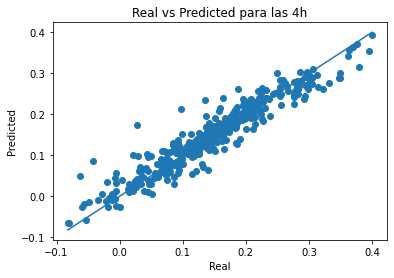

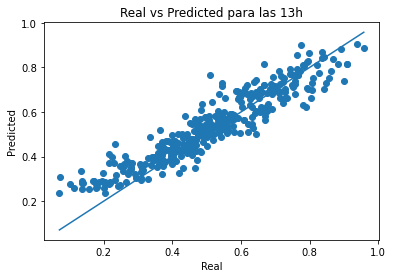

In [41]:
for h in min_max_hours:
    scatter_predictions (h,y_test[h],opt_predictions[h])

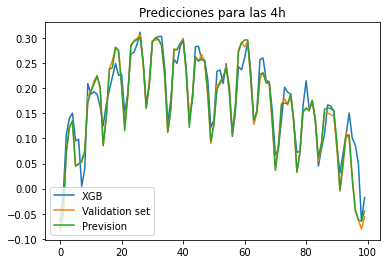

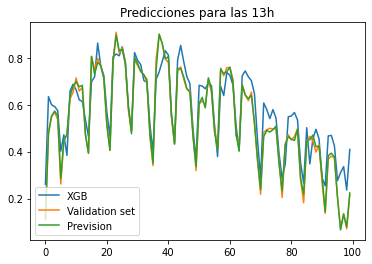

In [42]:
for h in min_max_hours:
    plot_evolution (h,y_test[h],opt_predictions[h],prevision_test[h])

SHAP INFORMATION FOR 4h
-------------------------





unclosed file <_io.BufferedReader name='C:\\Users\\david\\AppData\\Local\\Temp\\tmpnk3cyyj1\\model.ubj'>
NPY_ARRAY_UPDATEIFCOPY, NPY_ARRAY_INOUT_ARRAY, and NPY_ARRAY_INOUT_FARRAY are deprecated, use NPY_WRITEBACKIFCOPY, NPY_ARRAY_INOUT_ARRAY2, or NPY_ARRAY_INOUT_FARRAY2 respectively instead, and call PyArray_ResolveWritebackIfCopy before the array is deallocated, i.e. before the last call to Py_DECREF.
UPDATEIFCOPY detected in array_dealloc.  Required call to PyArray_ResolveWritebackIfCopy or PyArray_DiscardWritebackIfCopy is missing


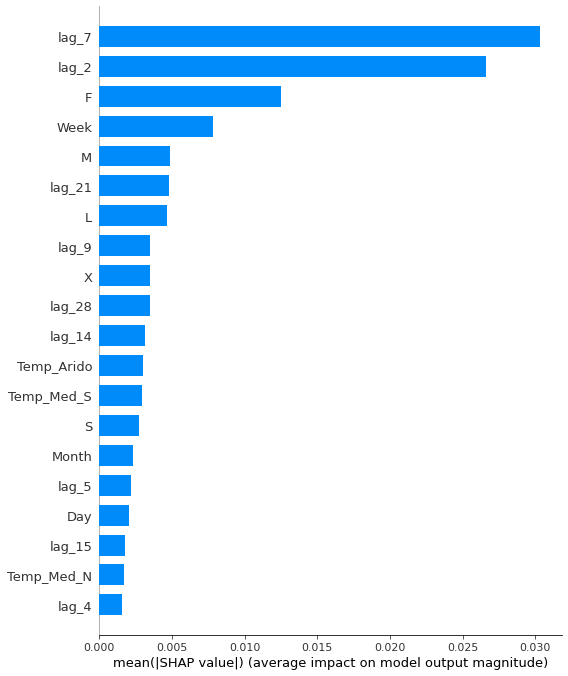

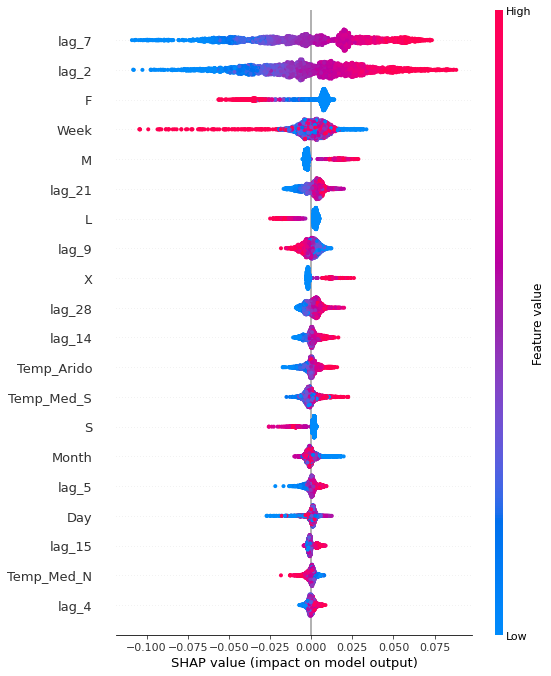

SHAP INFORMATION FOR 13h
-------------------------





unclosed file <_io.BufferedReader name='C:\\Users\\david\\AppData\\Local\\Temp\\tmpad4d2t9j\\model.ubj'>


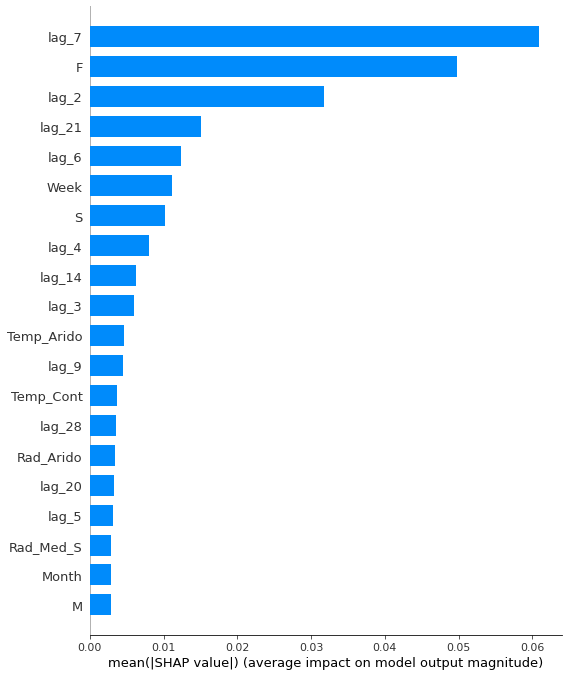

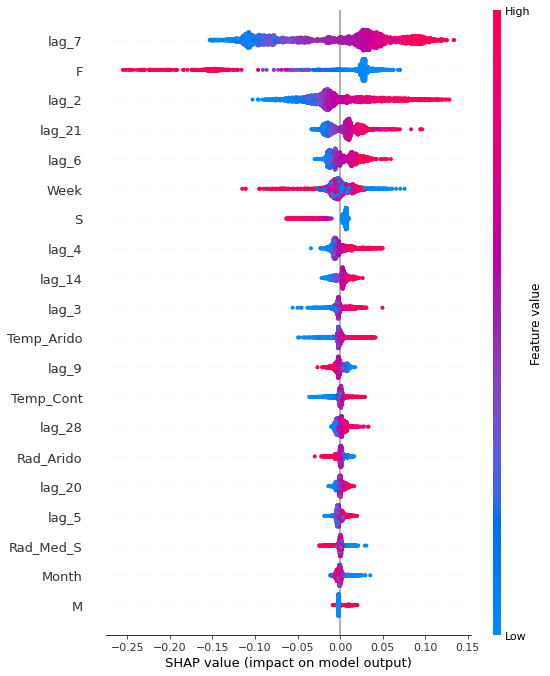

In [43]:
for h in min_max_hours:
    print ('SHAP INFORMATION FOR ' + str(h)+'h')
    print ('-------------------------\n\n\n')
    shap_information (forecaster_opt[h], y_train[h]+y_val[h], True, exog_train_val[h])

# LGBM/XGB without exog

In [44]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor

forecaster= {}

for h in range (24):

    # Crear el forecaster
    # ==============================================================================
    forecaster[h] = ForecasterAutoreg(
#                      regressor = LGBMRegressor(verbose=-1),
                     regressor = XGBRegressor (),
    #                  lags = [1, 2, 3] + [24*i-1 for i in range(1, 8)] + [24*i for i in range(1, 8)] + [24*i+1 for i in range(1, 8)]
                     lags = lags
                 )

    # Entrena el forecaster
    # ==============================================================================
    forecaster[h].fit(y=pd.Series(y_train[h]+y_val[h]))

In [45]:
normal_predictions = {}
for h in range (24):
    normal_predictions[h] = predict (forecaster[h], y[h], len(y_train[h]+y_val[h]), len(y_test[h]), False, _)

In [46]:
df_normal, normal_metrics = metrics(normal_predictions, y_test)
normal_metrics

[[0,
  1154.247894798766,
  854.2427406331797,
  3.5243921704824572,
  6280.285374517007],
 [1,
  987.5184259156898,
  717.3239737805028,
  3.1494190464096037,
  5688.484359158407],
 [2,
  916.7265248420106,
  666.3448081780776,
  3.0619071690856754,
  3672.1282757988665],
 [3,
  918.6080188037581,
  672.8724739932061,
  3.1780290050757865,
  3759.2603078786015],
 [4,
  882.4995461235751,
  649.4492438548467,
  3.1169288536539663,
  3637.8897875403673],
 [5,
  956.2617359694914,
  703.7153404119127,
  3.3669889616306268,
  4051.319609673101],
 [6,
  1135.786150182166,
  786.5182775883906,
  3.5044944334250494,
  4903.165023955527],
 [7,
  1572.1182864283135,
  1052.6679082080884,
  4.301972598620653,
  7730.525628550728],
 [8,
  1843.8813383861284,
  1182.3990559824,
  4.641493937892927,
  10177.374265198556],
 [9,
  1803.544960277055,
  1202.4983824623166,
  4.545184103153223,
  11763.280007013527],
 [10,
  1813.4505043893491,
  1290.6293677353813,
  4.825576922222708,
  10606.2582445

In [47]:
normal_metrics_mean = np.mean(np.array(normal_metrics),axis=0)
normal_metrics_mean = list (normal_metrics_mean [1:])
normal_metrics_mean

[1545.7521512870615, 1115.9041654540247, 4.314151837908763, 7524.091838537129]

In [49]:
min_max_hours = indexes_of_max_and_min_mae(normal_metrics)

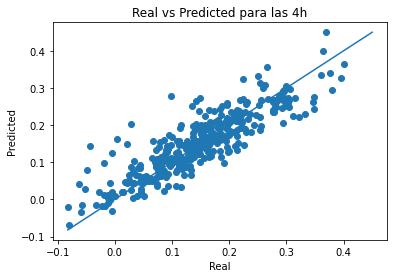

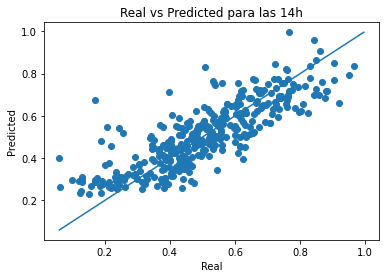

In [50]:
for h in min_max_hours:
    scatter_predictions (h,y_test[h],normal_predictions[h])

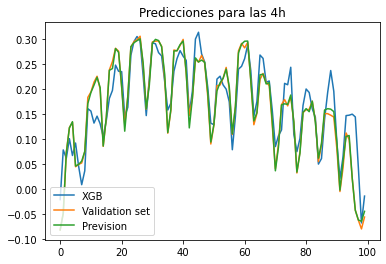

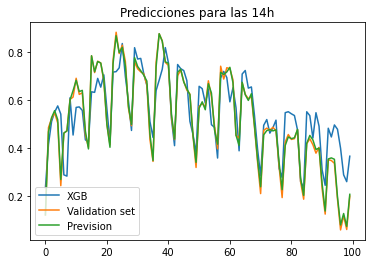

In [51]:
for h in min_max_hours:
    plot_evolution (h,y_test[h],normal_predictions[h],prevision_test[h])

SHAP INFORMATION FOR 4h


unclosed file <_io.BufferedReader name='C:\\Users\\david\\AppData\\Local\\Temp\\tmpsy51vdyd\\model.ubj'>
NPY_ARRAY_UPDATEIFCOPY, NPY_ARRAY_INOUT_ARRAY, and NPY_ARRAY_INOUT_FARRAY are deprecated, use NPY_WRITEBACKIFCOPY, NPY_ARRAY_INOUT_ARRAY2, or NPY_ARRAY_INOUT_FARRAY2 respectively instead, and call PyArray_ResolveWritebackIfCopy before the array is deallocated, i.e. before the last call to Py_DECREF.
UPDATEIFCOPY detected in array_dealloc.  Required call to PyArray_ResolveWritebackIfCopy or PyArray_DiscardWritebackIfCopy is missing


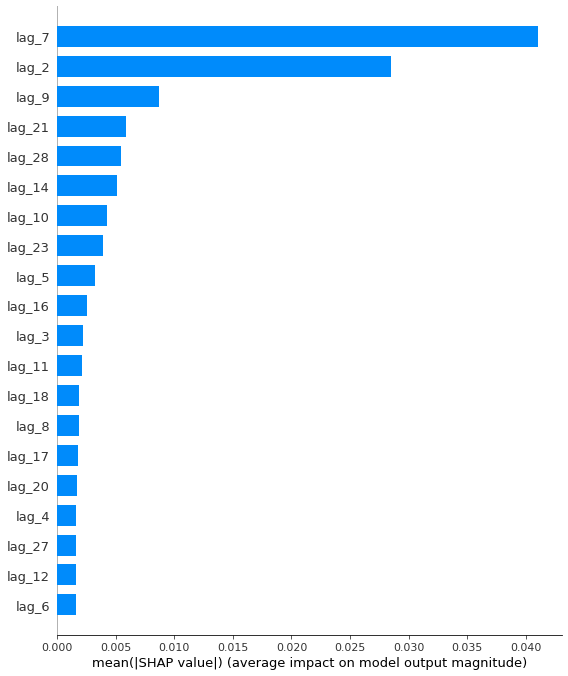

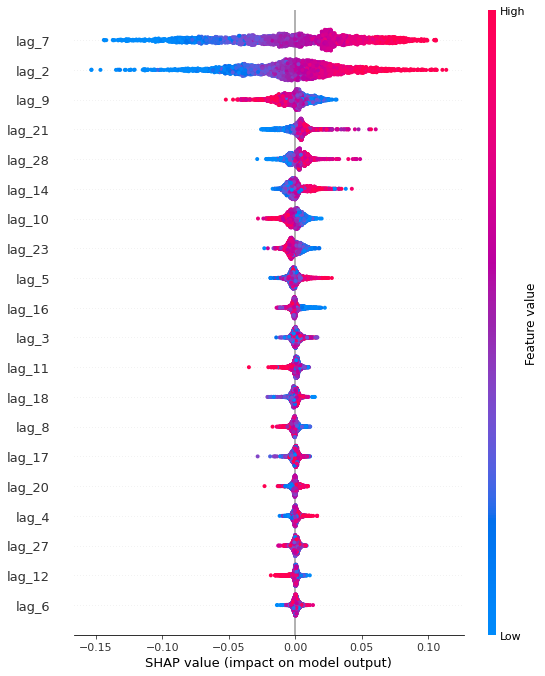

-------------------------



SHAP INFORMATION FOR 14h


unclosed file <_io.BufferedReader name='C:\\Users\\david\\AppData\\Local\\Temp\\tmpqvpttafg\\model.ubj'>


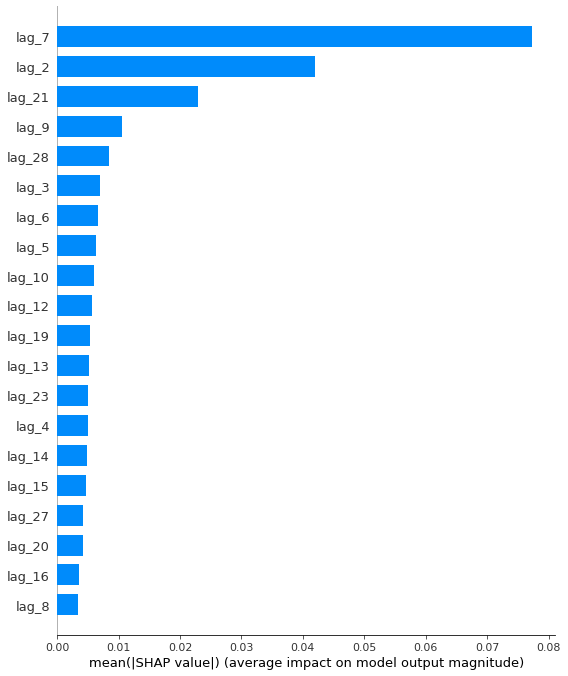

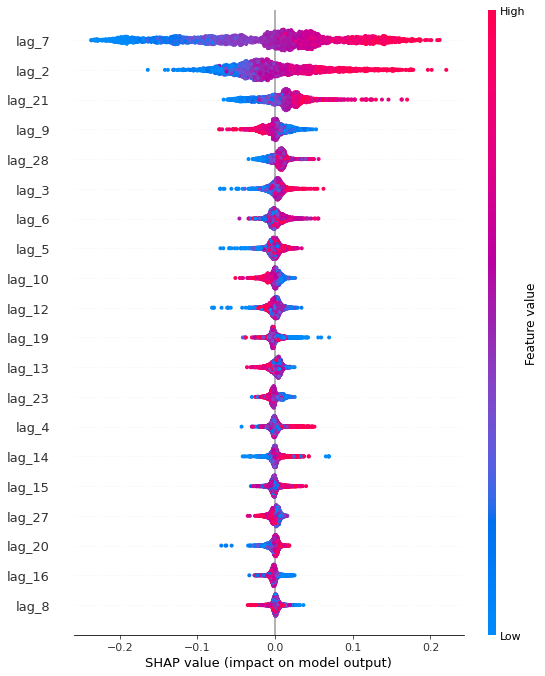

-------------------------





In [52]:
for h in min_max_hours:
    print ('SHAP INFORMATION FOR ' + str(h)+'h')
    shap_information (forecaster[h], y_train[h]+y_val[h], False,_)
    print ('-------------------------\n\n\n')

## Error Analysis

In [54]:
errors = {}
errors['Normal'] = normal_metrics_mean
errors['Opt'] = opt_metrics_mean
errors['Exog'] = exog_metrics_mean
errors = pd.DataFrame (errors)

errors = errors.rename(index={0: 'RMSE', 1: 'MAE', 2:'MAPE', 3:'MAX'})

errors

,Normal,Opt,Exog
RMSE,1545.752151,964.937741,1106.563408
MAE,1115.904165,729.664174,834.318065
MAPE,4.314152,2.833498,3.238036
MAX,7524.091839,4071.108762,4498.902544


In [55]:
df_errors = {}
df_errors ['Normal'] = df_normal
df_errors ['Exog'] = df_exog
df_errors ['Opt'] = df_opt

### Overall errors 

In [56]:
def hourly_error (type_of_error):
    errors_horas = {name:[] for name in df_errors.keys()}
    for name in errors_horas.keys():
        for i in range (24):
            auxdf = df_errors[name][df_errors[name]['Datetime'].dt.hour == i]
            if type_of_error == 'RMSE':
                errors_horas[name].append(np.sqrt(np.mean(auxdf['Squared Error'])))
            elif type_of_error == 'MAE':
                errors_horas[name].append(np.mean(auxdf['Absolute Error']))
            elif type_of_error == 'MAPE':
                errors_horas[name].append(np.mean(auxdf['Relative Error']))
            elif type_of_error == 'MAX':
                errors_horas[name].append(max(auxdf['Relative Error']))
            
    errors_horas = pd.DataFrame (errors_horas)
    plt.title(type_of_error + ' for different models')
    plt.xlabel('Hour')
    plt.plot(errors_horas, label=errors_horas.columns)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.plot()
    return errors_horas

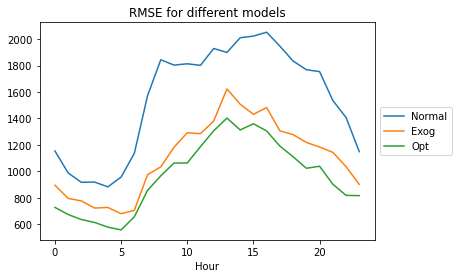

In [57]:
errors_horas_rmse = hourly_error ('RMSE')

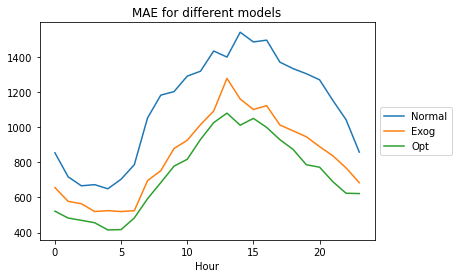

In [58]:
errors_horas_mae = hourly_error ('MAE')

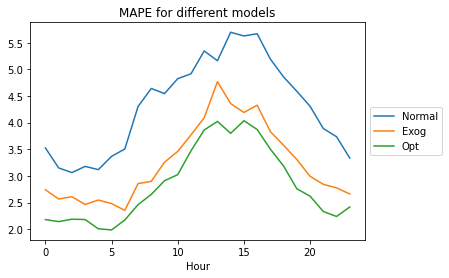

In [59]:
errors_horas_mape = hourly_error ('MAPE')

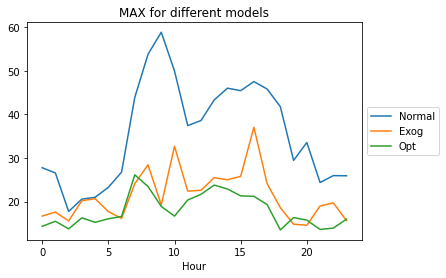

In [60]:
errors_horas_max = hourly_error ('MAX')

In [61]:
def weekly_error(type_of_error):
    errors_weekly = {name: [] for name in df_errors.keys()}
    for name in errors_weekly.keys():
        for i in range(7):
            auxdf = df_errors[name][df_errors[name]['Datetime'].dt.weekday == i]
            if type_of_error == 'RMSE':
                errors_weekly[name].append(np.sqrt(np.mean(auxdf['Squared Error'])))
            elif type_of_error == 'MAE':
                errors_weekly[name].append(np.mean(auxdf['Absolute Error']))
            elif type_of_error == 'MAPE':
                errors_weekly[name].append(np.mean(auxdf['Relative Error']))
            elif type_of_error == 'MAX':
                errors_weekly[name].append(max(auxdf['Absolute Error']))

    # Plot each set of errors separately
    for name, errors in errors_weekly.items():
        plt.plot(range(7), errors, label=name)  # Assuming 0-6 corresponds to Monday-Sunday
        
    plt.title(type_of_error + ' for different models')
    plt.xlabel('Day of the week')
    plt.xticks(range(7), ['L', 'M', 'X', 'J', 'V', 'S', 'D'])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    errors_weekly = pd.DataFrame(errors_weekly)
    return errors_weekly

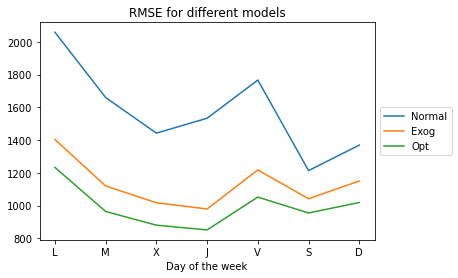

In [62]:
errors_weekly_rmse = weekly_error ('RMSE')

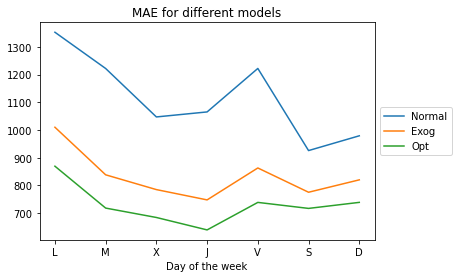

In [63]:
errors_weekly_mae = weekly_error ('MAE')

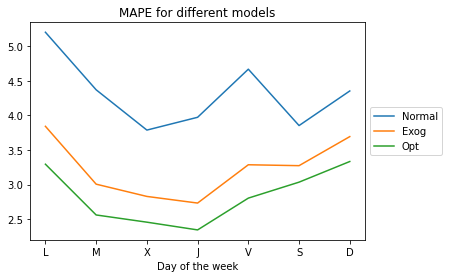

In [64]:
errors_weekly_mape = weekly_error ('MAPE')

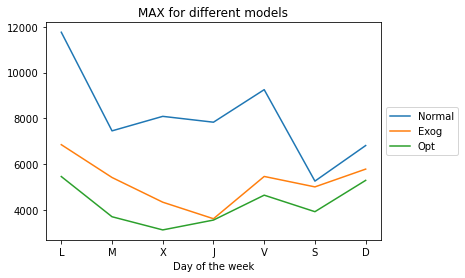

In [65]:
errors_weekly_max = weekly_error ('MAX')

## Histograms

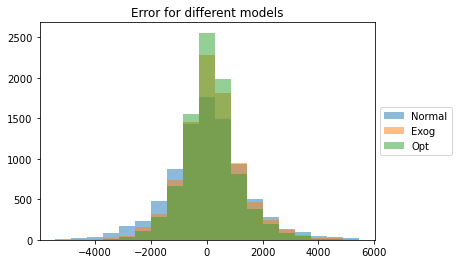

In [66]:
nbins = int (np.sqrt(len(y_test[0])))
# print (nbins)

for name in df_errors.keys():
    max_value = 0
    min_value = 0
    if max(df_errors[name]['Error']) >= max_value:
        max_value = max(df_errors[name]['Error'])
    if min(df_errors[name]['Error']) <= min_value:
        min_value = min(df_errors[name]['Error'])
bin_edges = np.linspace(min_value, max_value, nbins + 1)

plt.title('Error for different models')
for name in df_errors.keys():
    plt.hist(df_errors[name]['Error'], bins = bin_edges, label=name, alpha=0.5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [67]:
variables = ['mean', 'sigma', 'mean+-1sigma', 'mean+-2sigma', 'mean+-3sigma', 'mean+-4sigma']
nsigmas = 4

error_stats = pd.DataFrame()

for name in df_errors.keys():
    aux = []
    length = len(df_errors[name])
    mean = np.mean(df_errors[name]['Error'])
    aux.append(mean)
    sigma = np.std(df_errors[name]['Error'])
    aux.append(sigma)
    for n in range(1,nsigmas+1):
        auxdf = df_errors[name][(df_errors[name]['Error']>=mean-n*sigma) & (df_errors[name]['Error']<=mean+n*sigma)]
        aux.append(len(auxdf)/length)
    error_stats [name] = aux

error_stats.index = variables
error_stats

    

,Normal,Exog,Opt
mean,118.978287,168.607652,145.574420
sigma,1594.192696,1128.676764,990.269829
mean+-1sigma,0.778082,0.743836,0.746005
mean+-2sigma,0.946918,0.940982,0.940183
mean+-3sigma,0.982763,0.986872,0.987443
mean+-4sigma,0.993607,0.996804,0.997603


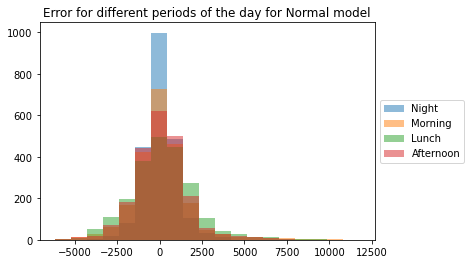

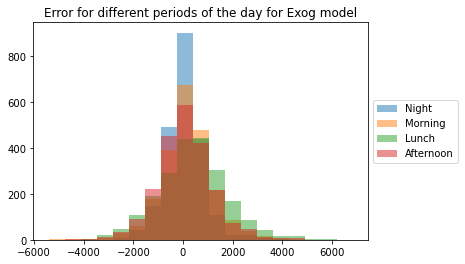

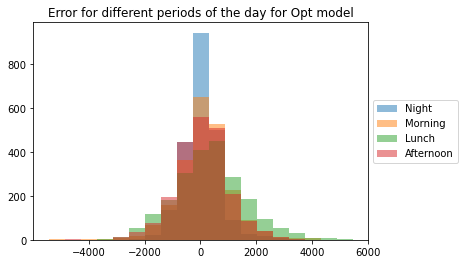

In [68]:
day_division = {
    'Night': [x for x in range (6)],
    'Morning': [x for x in range (6,12)],
    'Lunch': [x for x in range (12, 18)],
    'Afternoon': [x for x in range (18,24)]
    
}

nbins = int (np.sqrt(len(y_test[0])))
# print (nbins)

for name in df_errors.keys():
    plt.title('Error for different periods of the day for '+name+' model')
    max_value = 0
    min_value = 0
    for period in day_division.keys():
        auxdf = df_errors[name][df_errors[name]['Datetime'].dt.hour.isin(day_division[period])]
        if max(auxdf['Error']) >= max_value:
            max_value = max(auxdf['Error'])
        if min(auxdf['Error']) <= min_value:
            min_value = min(auxdf['Error'])
    bin_edges = np.linspace(min_value, max_value, nbins + 1)
    for period in day_division.keys():
        auxdf = df_errors[name][df_errors[name]['Datetime'].dt.hour.isin(day_division[period])]
        plt.hist(auxdf['Error'], bins = bin_edges, label=period, alpha=0.5)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()